In [28]:
import math
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'

# Calibration of CIR85

In [14]:
np.set_printoptions(suppress=True,
formatter={'all': lambda x: '%7.6f' % x})

import scipy.interpolate as sci
from scipy.optimize import fmin

In [15]:
# Zero-Coupon Bond Valuation Formula
def gamma(kappa_r, sigma_r):
    #helper function
    return math.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)
    
def b1(alpha):
    #helper function
    kappa_r, theta_r, sigma_r, r0, T = alpha
    g = gamma(kappa_r, sigma_r)
    return (((2 * g * math.exp((kappa_r + g) * T / 2)) /
    (2 * g + (kappa_r + g) * (math.exp(g * T) - 1)))
    ** (2 * kappa_r * theta_r / sigma_r ** 2))
    
def b2(alpha):
    #helper function
    kappa_r, theta_r, sigma_r, r0, T = alpha
    g = gamma(kappa_r, sigma_r)
    return ((2 * (math.exp(g * T) - 1)) /
    (2 * g + (kappa_r + g) * (math.exp(g * T) - 1)))
    
def B(alpha):
    ''' Function to value unit zero-coupon bonds in Cox-Ingersoll-Ross (1985)
        model.
        Parameters
        ==========
        r0: float
        initial short rate
        kappa_r: float
        mean-reversion factor
        theta_r: float
        long-run mean of short rate
        sigma_r: float
        volatility of short rate
        T: float
        time horizon/interval
        Returns
        =======
        zcb_value: float
        zero-coupon bond present value
                '''
    b_1 = b1(alpha)
    b_2 = b2(alpha)
    kappa_r, theta_r, sigma_r, r0, T = alpha
    return b_1 * math.exp(-b_2 * r0)

In [16]:
# Market Data: Eonia rate (01.10.2014) + Euribor rates
# Source: http://www.emmi-benchmarks.eu
# on 30. September 2014

t_list = np.array((1, 7, 14, 30, 60, 90, 180, 270, 360)) / 360.
r_list = np.array((-0.032, -0.013, -0.013, 0.007, 0.043,
                    0.083, 0.183, 0.251, 0.338)) / 100
factors = (1 + t_list * r_list)
zero_rates = 1 / t_list * np.log(factors)
r0 = r_list[0]

# Interpolation of Market Data
tck = sci.splrep(t_list, zero_rates, k=3) # cubic splines
tn_list = np.linspace(0.0, 1.0, 24)
ts_list = sci.splev(tn_list, tck, der=0)
de_list = sci.splev(tn_list, tck, der=1)
f = ts_list + de_list * tn_list

# forward rate transformation

def plot_term_structure():
    plt.figure(figsize=(8, 5))
    plt.plot(t_list, r_list, 'ro', label='rates')
    plt.plot(tn_list, ts_list, 'b', label='interpolation', lw=1.5)
    # cubic splines
    plt.plot(tn_list, de_list, 'g--', label='1st derivative', lw=1.5)
    # first derivative
    plt.legend(loc=0)
    plt.xlabel('time horizon in years')
    plt.ylabel('rate')
    plt.grid()

#
# Model Forward Rates
#
def CIR_forward_rate(opt):
    ''' Function for forward rates in CIR85 model.
        Parameters
        ==========
        kappa_r: float
        mean-reversion factor
        theta_r: float
        long-run mean
        sigma_r: float
        volatility factor
        Returns
        =======
        forward_rate: float
        forward rate
    '''
    kappa_r, theta_r, sigma_r = opt
    t = tn_list
    g = np.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)
    sum1 = ((kappa_r * theta_r * (np.exp(g * t) - 1)) /
            (2 * g + (kappa_r + g) * (np.exp(g * t) - 1)))
    sum2 = r0 * ((4 * g ** 2 * np.exp(g * t)) /
            (2 * g + (kappa_r + g) * (np.exp(g * t) - 1)) ** 2)
    forward_rate = sum1 + sum2
    return forward_rate

# Error Function
#
def CIR_error_function(opt):
    ''' Error function for CIR85 model calibration. '''
    kappa_r, theta_r, sigma_r = opt
    if 2 * kappa_r * theta_r < sigma_r ** 2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100
    forward_rates = CIR_forward_rate(opt)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)
    # print opt, MSE
    return MSE

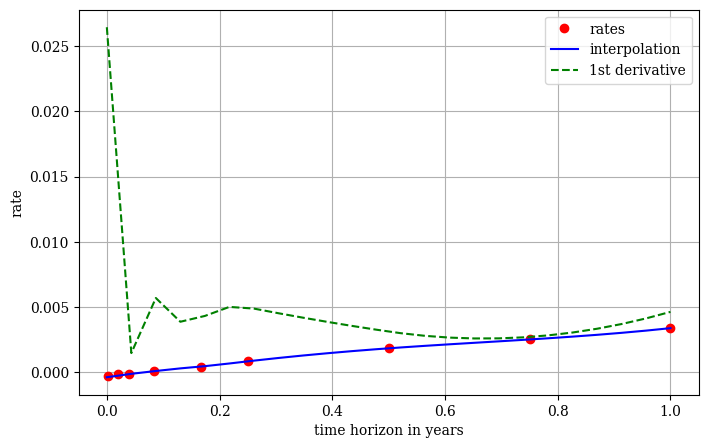

In [17]:
plot_term_structure()

In [18]:
# Calibration Procedure

def CIR_calibration():
    opt = fmin(CIR_error_function, [1.0, 0.02, 0.1],
    xtol=0.00001, ftol=0.00001,
    maxiter=300, maxfun=500)
    return opt

# Graphical Results Output
def plot_calibrated_frc(opt):
    ''' Plots market and calibrated forward rate curves. '''
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(8, 7))
    plt.subplot(211)
    plt.grid()
    plt.ylabel('forward rate $f(0,T)$')
    plt.plot(tn_list, f, 'b', label='market')
    plt.plot(tn_list, forward_rates, 'ro', label='model')
    plt.legend(loc=0)
    plt.axis([min(tn_list) - 0.05, max(tn_list) + 0.05,
            min(f) - 0.005, max(f) * 1.1])
    plt.subplot(212)
    plt.grid(True)
    wi = 0.02
    plt.bar(tn_list - wi / 2, forward_rates - f, width=wi)
    plt.xlabel('time horizon in years')
    plt.ylabel('difference')
    plt.axis([min(tn_list) - 0.05, max(tn_list) + 0.05,
            min(forward_rates - f) * 1.1, max(forward_rates - f) * 1.1])
    plt.tight_layout()
    
def plot_zcb_values(p0, T):
    ''' Plots unit zero-coupon bond values (discount factors). '''
    t_list = np.linspace(0.0, T, 20)
    r_list = B([r0, p0[0], p0[1], p0[2], t_list, T])
    plt.figure(figsize=(8, 5))
    plt.plot(t_list, r_list, 'b')
    plt.plot(t_list, r_list, 'ro')
    plt.xlabel('time horizon in years')
    plt.ylabel('unit zero-coupon bond value')
    plt.grid()

In [19]:
opt = CIR_calibration()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 270
         Function evaluations: 485


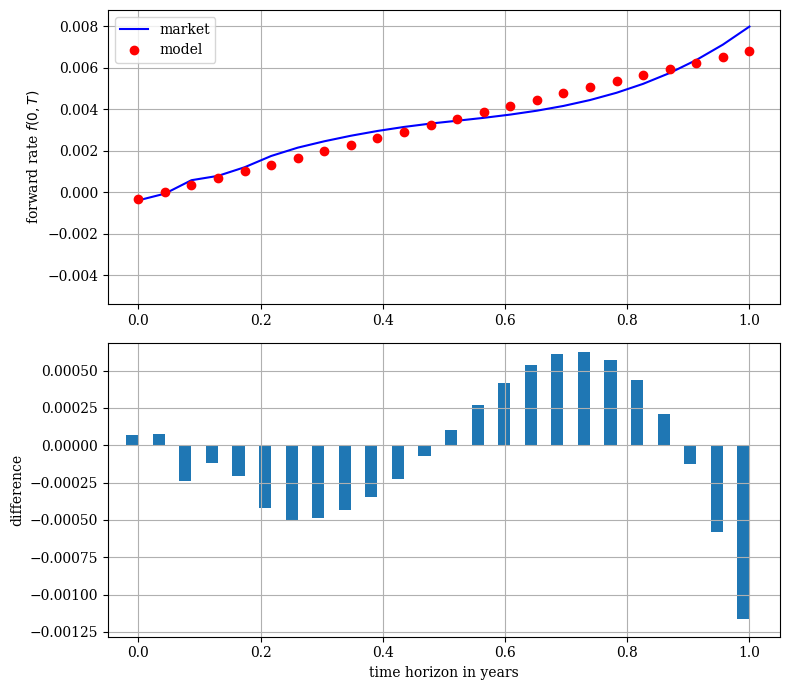

In [20]:
plot_calibrated_frc(opt)

# Heston93 Model Calibration

In [32]:
from scipy.integrate import quad

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.

    Parameter definitions see function BCC_call_value.'''
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 -
                  sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) \
        / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r * u * 1j * T + (c1 / sigma_v ** 2) *
          ((kappa_v - rho * sigma_v * u * 1j + c2) * T -
           2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 *
          ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value
    
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: integration function.

    Parameter definitions see function H93_call_value.'''
    char_func_value = H93_char_func(u - 1j * 0.5, T, r, kappa_v,
                                    theta_v, sigma_v, rho, v0)
    int_func_value = 1 / (u ** 2 + 0.25) \
        * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value
    
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    ''' Valuation of European call option in Heston 93 model via Lewis (2001)
    Fourier-based approach.

    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance

    Returns
    =======
    call_value: float
        present value of European call option

    '''
    int_value = quad(lambda u: H93_int_func(u, S0, K, T, r, kappa_v,
                                            theta_v, sigma_v, rho, v0),
                     0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) /
                     np.pi * int_value)
    return call_value

In [33]:
import pandas as pd

# Calibrate Short Rate Model
kappa_r, theta_r, sigma_r = CIR_calibration()

# Market Data from www.eurexchange.com
# as of 30. September 2014
h5 = pd.HDFStore('option_data.h5', 'r')
data = h5['data'] # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93 # EURO STOXX 50 level 30.09.2014
r0 = r_list[0] # initial short rate

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 270
         Function evaluations: 485


In [34]:
# Option Selection
tol = 0.02 # percent ITM/OTM options
options = data[(np.abs(data['Strike'] - S0) / S0) < tol]
mats = sorted(set(options['Maturity']))
options = options[options['Maturity'] == mats[0]]
options['Date'] = pd.DatetimeIndex(options['Date'])
options['Maturity'] = pd.DatetimeIndex(options['Maturity'])
options.head()

,Date,Strike,Call,Maturity,Put
456,2014-09-30,3175.0,82.3,2014-10-17,24.5
457,2014-09-30,3200.0,64.3,2014-10-17,31.5
458,2014-09-30,3225.0,48.3,2014-10-17,40.5
459,2014-09-30,3250.0,34.6,2014-10-17,51.8
460,2014-09-30,3275.0,23.5,2014-10-17,65.8


In [35]:
# Adding Time-to-Maturity and Short Rates
for row, option in options.iterrows():
    T = (option['Maturity'] - option['Date']).days / 365.
    options.loc[row, 'T'] = T
    B0T = B([kappa_r, theta_r, sigma_r, r0, T])
    options.loc[row, 'r'] = -math.log(B0T) / T

In [36]:
from scipy.optimize import brute, fmin, minimize

# Calibration Functions
i = 0
min_MSE = 500

def H93_error_function(p0):
    ''' Error function for parameter calibration in BCC97 model via
        Lewis (2001) Fourier approach.
        Parameters
        ==========
        kappa_v: float
        mean-reversion factor
        theta_v: float
        long-run mean of variance
        sigma_v: float
        volatility of variance
        rho: float
        correlation between variance and stock/index level
        v0: float
        initial, instantaneous variance
        Returns
        =======
        MSE: float
        mean squared error
    '''
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v ** 2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                                     option['r'], kappa_v, theta_v, sigma_v, rho, v0)
        se.append((model_value - option['Call']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE

def H93_calibration_full():
    ''' Calibrates H93 stochastic volatility model to market quotes. '''
    # first run with brute force
    # (scan sensible regions)
    p0 = brute(H93_error_function,
                ((2.5, 10.6, 5.0), # kappa_v
                (0.01, 0.041, 0.01), # theta_v
                (0.05, 0.251, 0.1), # sigma_v
                (-0.75, 0.01, 0.25), # rho
                (0.01, 0.031, 0.01)), # v0
                finish=None)
    # second run with local, convex minimization
    # (dig deeper where promising)
    opt = fmin(H93_error_function, p0,
                xtol=0.000001, ftol=0.000001,
                maxiter=750, maxfun=900)
    return opt
def H93_calculate_model_values(p0):
    ''' Calculates all model values given parameter vector p0. '''
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    values = []
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                                     option['r'], kappa_v, theta_v, 
                                     sigma_v, rho, v0)
        values.append(model_value)
    return np.array(values)

In [37]:
p0 = H93_calibration_full()

   0 | [2.500000 0.010000 0.050000 -0.750000 0.010000] | 366.873 | 366.873
  25 | [2.500000 0.020000 0.050000 -0.750000 0.020000] |  79.547 |   8.913
  50 | [2.500000 0.020000 0.250000 -0.750000 0.030000] |   6.848 |   6.848
  75 | [2.500000 0.030000 0.150000 -0.500000 0.010000] | 318.921 |   6.848
 100 | [2.500000 0.040000 0.050000 -0.500000 0.020000] |  63.893 |   6.586
 125 | [2.500000 0.040000 0.250000 -0.500000 0.030000] |   8.001 |   6.586
 150 | [7.500000 0.010000 0.150000 -0.250000 0.010000] | 369.077 |   6.586
 175 | [7.500000 0.020000 0.050000 -0.250000 0.020000] |  80.229 |   6.586
 200 | [7.500000 0.020000 0.250000 -0.250000 0.030000] |  11.110 |   6.586
 225 | [7.500000 0.030000 0.150000 0.000000 0.010000] | 245.368 |   6.586
 250 | [7.500000 0.040000 0.050000 0.000000 0.020000] |  41.811 |   6.586
 275 | [7.500000 0.040000 0.250000 0.000000 0.030000] |  12.098 |   6.586
 300 | [1.678065 0.032639 0.306240 -0.925055 0.030497] |   4.801 |   4.627
 325 | [1.697625 0.030823 0.

C:\Users\harki\AppData\Local\Temp\ipykernel_10912\2857263715.py:58: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(H93_error_function, p0,


In [39]:
H93_calculate_model_values(p0)

array([81.942847, 64.476243, 48.660418, 34.772168, 23.084396])